In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv("PKEY_TLS_10x10.xyzch")

In [3]:
df.sample(10)

,X,Y,Z,Classification,HeightAboveGround
4561442,246115.429,168839.793,2.042,1.0,3.087
36580811,246120.631,168848.738,-1.103,2.0,0.000
47325733,246119.647,168849.016,4.042,1.0,5.140
2560154,246116.809,168841.071,-1.046,2.0,0.000
41832589,246122.435,168841.008,4.766,1.0,5.796
7035816,246121.486,168839.757,0.617,1.0,1.728
26875586,246122.223,168842.769,-1.006,2.0,0.000
42577940,246122.093,168842.263,4.322,1.0,5.092
3131928,246116.663,168841.469,-1.060,2.0,0.000
17221960,246121.071,168842.334,3.035,1.0,4.038


In [4]:
df.count()[0]

48537757

In [5]:
df = df.sample(30000000)

In [6]:
df.count()[0]

30000000

In [7]:
x_max = df.X.max()
x_min = df.X.min()
y_max = df.Y.max()
y_min = df.Y.min()
z_max = df.Z.max()
z_min = df.Z.min()
print(x_max, x_min, y_max, y_min, z_max, z_min)

246124.59 246114.59 168849.55 168839.55 9.441 -1.259


In [8]:
# c = 0
site_L = x_max - x_min
site_W = y_max - y_min
site_A = site_L * site_W
voxel_dim = 1.0

replicates = []
for frac in np.around(np.linspace(0.01,1,10),2):
    start = time.time()
    z0_list = []
    for rep in range(10):
        window_max_h = []
        voxel_count = []
        voxels = 0
        df_s = df.sample(frac=frac, replace=False)
        pts = df_s.count()[0]
        for i in np.arange(x_min, x_max, voxel_dim):
            for j in np.arange(y_min, y_max, voxel_dim):
                df_window = df_s[(df_s['X'].between(i, i+voxel_dim)) &
                                 (df_s['Y'].between(j, j+voxel_dim))]
                window_max_h.append(df_window.HeightAboveGround.max())
                for k in np.arange(z_min, z_max, voxel_dim):
                    df_voxel = df_s[(df_s['X'].between(i, i+voxel_dim)) &
                                    (df_s['Y'].between(j, j+voxel_dim)) &
                                    (df_s['Z'].between(k, k+voxel_dim))]
                    voxel_count.append(df_voxel.count()[0])
                    voxels += 1
        mu = np.median([c for c in voxel_count if c != 0])
        vi = [min(p/mu,1.0)*voxel_dim**3 for p in voxel_count]
        S_star = np.sum(vi)
        A_star = voxels * voxel_dim**3
        H_star = np.mean(window_max_h)
        z0_list.append(0.5*H_star*S_star/A_star)
        if frac == 1.0: break
    replicates.append([frac, z0_list, pts, pts/site_A, voxels])
    end = time.time()
    print(f"{frac} {np.around(np.mean(z0_list),3)} +/- {np.around(np.std(z0_list),3)} >>> took {np.around((end - start)/60.0,0)} minutes") 

# print results using densest (last) point cloud
print(f"H* = {H_star}   S* = {S_star}   A* = {A_star}   z0 = {0.5*H_star*S_star/A_star}")

0.01 2.269 +/- 0.019 >>> took 1.0 minutes
0.12 2.431 +/- 0.005 >>> took 11.0 minutes
0.23 2.449 +/- 0.006 >>> took 19.0 minutes
0.34 2.458 +/- 0.005 >>> took 22.0 minutes
0.45 2.466 +/- 0.003 >>> took 35.0 minutes
0.56 2.469 +/- 0.005 >>> took 42.0 minutes
0.67 2.473 +/- 0.004 >>> took 51.0 minutes
0.78 2.476 +/- 0.003 >>> took 57.0 minutes
0.89 2.48 +/- 0.001 >>> took 64.0 minutes
1.0 2.481 +/- 0.0 >>> took 7.0 minutes
H* = 9.00897   S* = 605.880421382943   A* = 1100.0   z0 = 2.4810720635574057


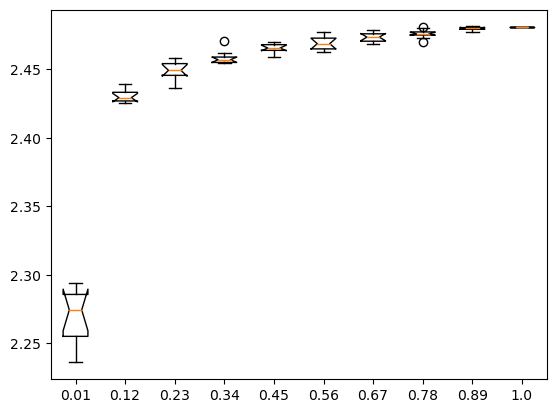

In [9]:
# check plot, not for publication
fig, ax = plt.subplots()
ax.boxplot([y[1] for y in replicates],
           notch=True,  # notch shape
           vert=True,  # vertical box alignment
           labels=[x[0] for x in replicates]);

In [10]:
# export results for plotting in another notebook
with open('PKEY_replicates_max', 'w') as outfile:
    outfile.write('\n'.join(str(i) for i in replicates))
    
# once this was complete, commas were manually inserted in the last row (frac = 1.0)
# so that fields r1 through r9, representing replicates 2 through 10, would match
# the overall schema.